# __Set Up & Import__

## Import Necessary Library

In [ ]:
# %pip install opencv-python
# %pip install mediapipe
# %pip install plotly
# %pip install pandas

In [2]:
import cv2
import mediapipe as mp
import pandas as pd
import numpy as np
import ast
import matplotlib.pyplot as plt
import os
import time 


## Set Color Class [ _Not Important_ ]

In [3]:
class color:
   PINK = '\033[95m'
   CYAN = '\033[96m'
   PURPLE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

## Set Up Detection Model

In [4]:
mp_holistic = mp.solutions.holistic
holistic_model = mp_holistic.Holistic(
    min_detection_confidence=0.1,
    min_tracking_confidence=0.1
)

# Initializing the drawing utils for drawing the landmarks on image
mp_drawing = mp.solutions.drawing_utils

# __Define Needed Function__

## Extract & Structerize Position From Each Part

In [5]:
def extract_data(hand_pos):
    right, left, body, i = dict(), dict(), dict(), 0
    if hand_pos[0] != None:
        for data in hand_pos[0].landmark:
            right['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        right = None

    if hand_pos[1] != None:
        for data in hand_pos[1].landmark:
            left['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        left = None

    if hand_pos[2] != None:
        for data in hand_pos[2].landmark:
            body['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        body = None

    if hand_pos[3] != None:
        for data in hand_pos[3].landmark:
            face['Landmark '+str(i)] = [data.x, data.y, data.z]
            i+=1
        i = 0
    else:
        face = None

    hand_pos = {'Right': right, 'Left': left, 'Body': body}
    hand_pos_df = pd.DataFrame(hand_pos).T
    
    return hand_pos_df

## Main Function

In [6]:
def operate(mp_holistic,holistic_model, mp_drawing, file):    
    vid = cv2.VideoCapture(file)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Draw Face Land Marks
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_CONTOURS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper, face])
        os.makedirs(file.split('.')[0], exist_ok=True)
        hand_pos_df.to_csv(file.split('.')[0]+'/Frame_'+str(total_capture-1)+'.csv')
        print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    vid.release()
    cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

## Graph Drawing

In [7]:
edges = {
        "left_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "right_hand": [
            (0, 1), (1, 2), (2, 3), (3, 4), (0, 5), (0, 17), (5, 6), (6, 7),
            (7, 8), (5, 9), (9, 10), (10, 11), (11, 12), (9, 13), (13, 14),
            (14, 15), (15, 16), (13, 17), (17, 18), (18, 19), (19, 20)
        ],
        "pose": [
            (8, 6), (6, 5), (6, 4), (4, 0), (0, 1), (1, 2), (2, 3), (3, 7),
            (10, 9), (11, 12), (11, 13), (11, 23), (13, 15), (15, 21), (15, 17),
            (15, 19), (17, 19), (12, 14), (12, 24), (14, 16), (16, 22), (16, 20),
            (16, 18), (18, 20), (23, 24)
        ],
    }

In [8]:
def draw_edges(ax, points, edges):
        for edge in edges:
            start, end = edge
            x_values = [points[start][0], points[end][0]]
            y_values = [points[start][1], points[end][1]]
            ax.plot(x_values, y_values, 'k-')

In [9]:
def graph_drawer(word, frames ,edges):
    frame = pd.read_csv(word+'/frame_'+str(frames)+'.csv')
        
    # Extract data from the CSV file
    lst_frame_right = frame.iloc[0][1:].to_frame().dropna().values
    lst_frame_left = frame.iloc[1][1:].to_frame().dropna().values
    lst_frame_body = frame.iloc[2][1:].to_frame().dropna().values
    lst_frame_face = frame.iloc[3][1:].to_frame().dropna().values

    # Convert string representations of lists to actual lists
    lst_frame_right = [ast.literal_eval(lst_frame_right[i][0]) for i in range(len(lst_frame_right))]
    lst_frame_left = [ast.literal_eval(lst_frame_left[i][0]) for i in range(len(lst_frame_left))]
    lst_frame_body = [ast.literal_eval(lst_frame_body[i][0]) for i in range(len(lst_frame_body))]
    lst_frame_face = [ast.literal_eval(lst_frame_face[i][0]) for i in range(len(lst_frame_face))]

    # Extract x and y coordinates
    right_x = [lst_frame_right[i][0] for i in range(len(lst_frame_right))]
    right_y = [lst_frame_right[i][1] for i in range(len(lst_frame_right))]
    left_x = [lst_frame_left[i][0] for i in range(len(lst_frame_left))]
    left_y = [lst_frame_left[i][1] for i in range(len(lst_frame_left))]
    body_x = [lst_frame_body[i][0] for i in range(len(lst_frame_body))]
    body_y = [lst_frame_body[i][1] for i in range(len(lst_frame_body))]
    face_x = [lst_frame_face[i][0] for i in range(len(lst_frame_face))]
    face_y = [lst_frame_face[i][1] for i in range(len(lst_frame_face))]

    # Create the plot
    _, axis = plt.subplots(2, 2, constrained_layout=True, figsize=(8, 8))
    if right_x != []:
        axis[0, 0].scatter(right_x, right_y)
        axis[0, 0].set_title("Right hand")
        draw_edges(axis[0, 0], lst_frame_right, edges["right_hand"])

    if left_x != []:
        axis[0, 1].scatter(left_x, left_y)
        axis[0, 1].set_title("Left hand")
        draw_edges(axis[0, 1], lst_frame_left, edges["left_hand"])

    if body_x != []:
        axis[1, 0].scatter(body_x, body_y)
        axis[1, 0].set_title("Body")
        draw_edges(axis[1, 0], lst_frame_body, edges["pose"])

    if right_x != [] and left_x != [] and body_x != []:
        axis[1, 1].scatter(right_x, right_y)
        axis[1, 1].scatter(left_x, left_y)
        axis[1, 1].scatter(body_x, body_y)
        axis[1, 1].set_title("All")
        draw_edges(axis[1, 1], lst_frame_right, edges["right_hand"])
        draw_edges(axis[1, 1], lst_frame_left, edges["left_hand"])
        draw_edges(axis[1, 1], lst_frame_body, edges["pose"])

    axis[0,0].yaxis.set_inverted(True)
    axis[0,1].yaxis.set_inverted(True)
    axis[1,0].yaxis.set_inverted(True)
    axis[1,1].yaxis.set_inverted(True)
    plt.show()

# __Using Zone__

In [10]:
operate(mp_holistic,holistic_model, mp_drawing, 'hello1.mp4')

Successfully captured frame: 30 / 30
Done!


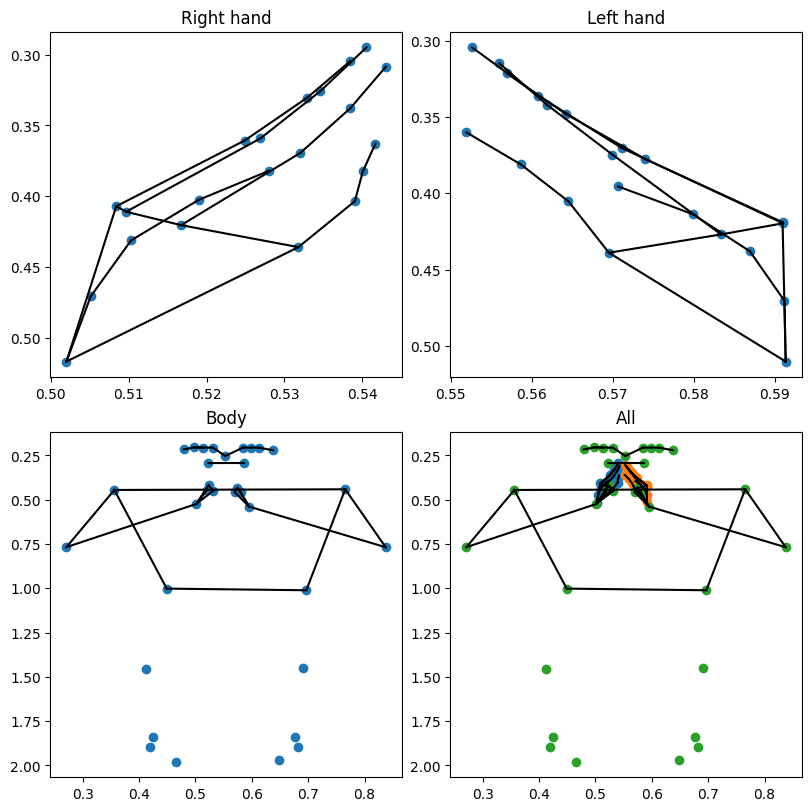

In [12]:
graph_drawer('hello1 test', 10, edges)

# __KeyPoint Folder__

In [ ]:
def operate2(mp_holistic,holistic_model, mp_drawing, file,folder_path,index):
    vdo_path = os.path.join('VDO',folder_path, file)
    os.mkdir('Landmarked/' + folder_path+'/'+str(index))
    vid = cv2.VideoCapture(vdo_path)
    total_frame, total_capture = int(vid.get(cv2.CAP_PROP_FRAME_COUNT)), 0

    for i in range(total_frame):
        if i%(total_frame//30) == 0:
            total_capture+=1
        else:
            continue
        ret, frame = vid.read()

        vid.set(cv2.CAP_PROP_POS_FRAMES, (total_capture)*(total_frame/30))

        if not ret or cv2.waitKey(5) & 0xFF == ord('q'):
            break
        
        image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        image.flags.writeable = False
        results = holistic_model.process(image)
        image.flags.writeable = True
    
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)

        # Draw Pose And Face Land Marks 
        mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS)
        # Drawing Right hand Land Marks
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
        # Drawing Left hand Land Marks
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

        # Display the resulting image
        cv2.imshow("Display", image)

        left= results.left_hand_landmarks
        right = results.right_hand_landmarks
        upper = results.pose_landmarks
        hand_pos_df = extract_data([right, left, upper])
        hand_pos_df.to_csv('Landmarked/'+folder_path + '/' +str(index) +'/'+str(total_capture-1)+'.csv')
        # print("\r"+"Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30", end="")
        # print("Successfully captured frame:", color.RED+color.BOLD+str(total_capture)+color.END+" / 30")

    # vid.release()
    # cv2.destroyAllWindows()
    print("\n"+color.BOLD+color.GREEN+"Done!"+color.END)

In [ ]:
def landmark_folder(folder_path):
    for word_folder in os.listdir(folder_path):
        if word_folder == '.DS_Store':
            continue
        print(f'กำลัง keypoint {word_folder}...')
        files = os.listdir(f'VDO/{word_folder}')
        os.mkdir('Landmarked/' + word_folder)
        for index,file in enumerate(files):
            operate2(mp_holistic,holistic_model, mp_drawing, file,word_folder,index)
    print("เสร็จหมดละจ้าา")

In [ ]:
"""
ให้ใส่ชื่อ Folder ที่ต้องการ landmark โดยมันจะไปอยู่ในโฟลเดอร์ Landmarked อีกที ให้สร้างด้วยนะจ๊ะ
พอได้ไฟล์แล้ว เอาไปใส่ในไดร์ฟ อย่าอัปขึน git ไม่งั้น บู้มมมมมมมมมมม 
"""
landmark_folder('VDO')

# __Capture__

In [ ]:
stop_recording = False

def capture(word,count):
    global stop_recording
    webcam = cv2.VideoCapture(0)

    if not webcam.isOpened():
        # print("ไม่สามารถเปิด webcam ได้")
        exit()

    frame_width = int(webcam.get(4))
    frame_height = int(webcam.get(4))

    fps = int(webcam.get(cv2.CAP_PROP_FPS))
    print(f"คำว่า : '{word}' ครั้งที่ {count}")
    # print("Webcam FPS:", fps)

    fourcc = cv2.VideoWriter_fourcc(*"mp4v")
    out = cv2.VideoWriter(f"VDO/{word}/{word}_re_{count}.mp4", fourcc, fps, (frame_width, frame_height))

    while not stop_recording:
        ret, frame = webcam.read()

        if ret:
            frame = cv2.flip(frame, 1)
            pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
            draw = ImageDraw.Draw(pil_img)

            font_path = "SukhumvitSet-Medium.ttf"
            font = ImageFont.truetype(font_path, 120)
            font2 = ImageFont.truetype(font_path, 50)

            draw.text((50, 50), word, font=font, fill=(255, 255, 255))
            draw.text((50,200), f'คลิปที่ : {count}', font=font, fill=(255, 255, 255))
            draw.text((1500,50), 'กด q เมื่อบันทึกเสร็จ', font=font2, fill=(255, 255, 255))
            draw.text((1500,200), 'กด d เพื่อยกเลิก', font=font2, fill=(255, 255, 255))

            frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)

            cv2.imshow("Webcam", frame)
            out.write(frame)

        if cv2.waitKey(100) & 0xFF == ord("q"):
            break

    webcam.release()
    out.release()
    cv2.destroyAllWindows()

In [ ]:
def cap_sl(word):
    global stop_recording
    ex_vdo = cv2.VideoCapture(f'VDO/{word}/{word}_test.mp4')
    while True:
        ret, frame = ex_vdo.read()

        if not ret:
            print("ไม่สามารถอ่านไฟล์ได้")
            break

        pil_img = Image.fromarray(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        draw = ImageDraw.Draw(pil_img)

        font_path = "SukhumvitSet-Medium.ttf"
        font = ImageFont.truetype(font_path, 50)

        text_position = (50, 50)
        draw.text(text_position, word, font=font, fill=(255, 255, 255))

        frame = cv2.cvtColor(np.array(pil_img), cv2.COLOR_RGB2BGR)
        cv2.imshow('Example Video', frame)

        if cv2.waitKey(25) & 0xFF == ord('q'):
            break
    ex_vdo.release()
    cv2.destroyAllWindows()
    
    time.sleep(3)
    for i in range(1,30):
        capture(word,i)
        time.sleep(5)
        if cv2.waitKey(100) & 0xFF == ord('d'):
            stop_recording = True
            break
        
    print('เสร็จแล้ววว')